# Регрессия

## Шаг 0. Импорт необходимых библиотек

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from scipy import stats  # Для проведения статистических тестов


## Шаг 1. Загрузка и предварительная обработка данных

In [19]:
df = pd.read_csv('auto-mpg.csv')
df.head()
df.info()
# Вывод количества пропусков по столбцам
print(df.isnull().sum())
# Удаляем строки с пропущенными значениями
df.dropna(inplace=True)
# Удаляем дубликаты
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"\nУдалено дубликатов: {initial_shape[0] - df.shape[0]} строк(и)")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

Удалено дубликатов: 0 строк(и)


## Шаг 2. Определение типов данных и шкал измерения

In [20]:
# Просмотр типов данных
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [21]:

# Приведение категориальных переменных к типу 'category'
df['origin'] = df['origin'].astype('category')
# Поле 'car name' оставляем как строку, поскольку оно не участвует в анализе

# Определение шкал измерения:
# - mpg: Количественная переменная, шкала отношений (истинный ноль, пропорциональность интервалов).
# - cylinders: Количественная переменная, может интерпретироваться как порядковая при анализе распределения.
# - displacement, horsepower, weight, acceleration: Количественные переменные, шкала отношений.
# - model year: Количественная переменная, шкала интервальная.
# - origin: Категориальная (номинальная) переменная, отражающая регион производства.
# - car name: Строковая переменная (идентификатор модели).


## Шаг 3. Визуализация данных

### 3.1 График зависимости расхода топлива (mpg) от массы автомобиля (weight)

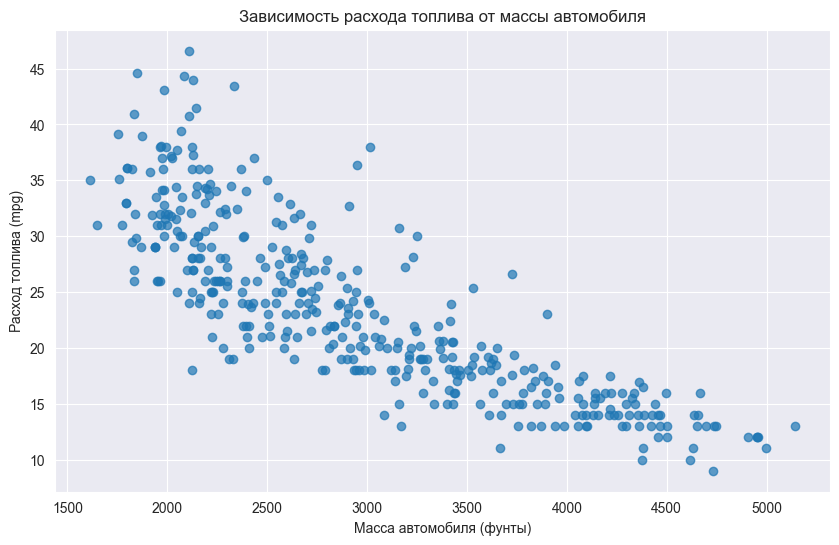

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(df['weight'], df['mpg'], alpha=0.7)
plt.xlabel('Масса автомобиля (фунты)')
plt.ylabel('Расход топлива (mpg)')
plt.title('Зависимость расхода топлива от массы автомобиля')
plt.grid(True)
plt.show()


### 3.2 Боксплоты распределения расхода топлива по группам 'origin'

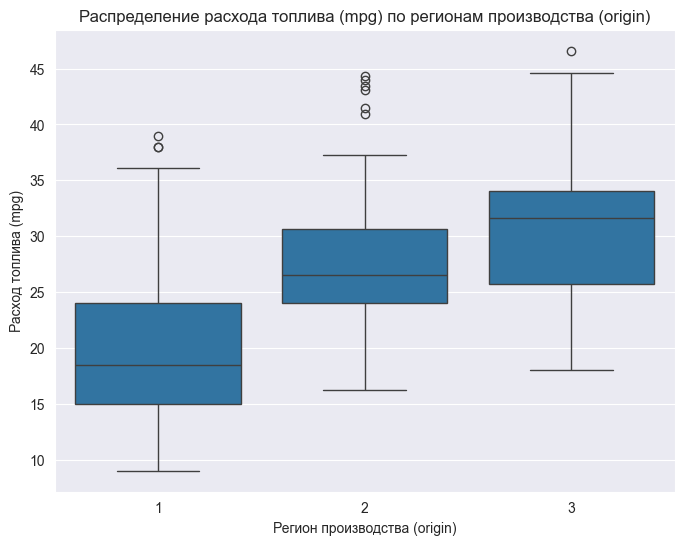

In [23]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='origin', y='mpg', data=df)
plt.title('Распределение расхода топлива (mpg) по регионам производства (origin)')
plt.xlabel('Регион производства (origin)')
plt.ylabel('Расход топлива (mpg)')
plt.show()


### 3.3 Гистограммы для основных признаков

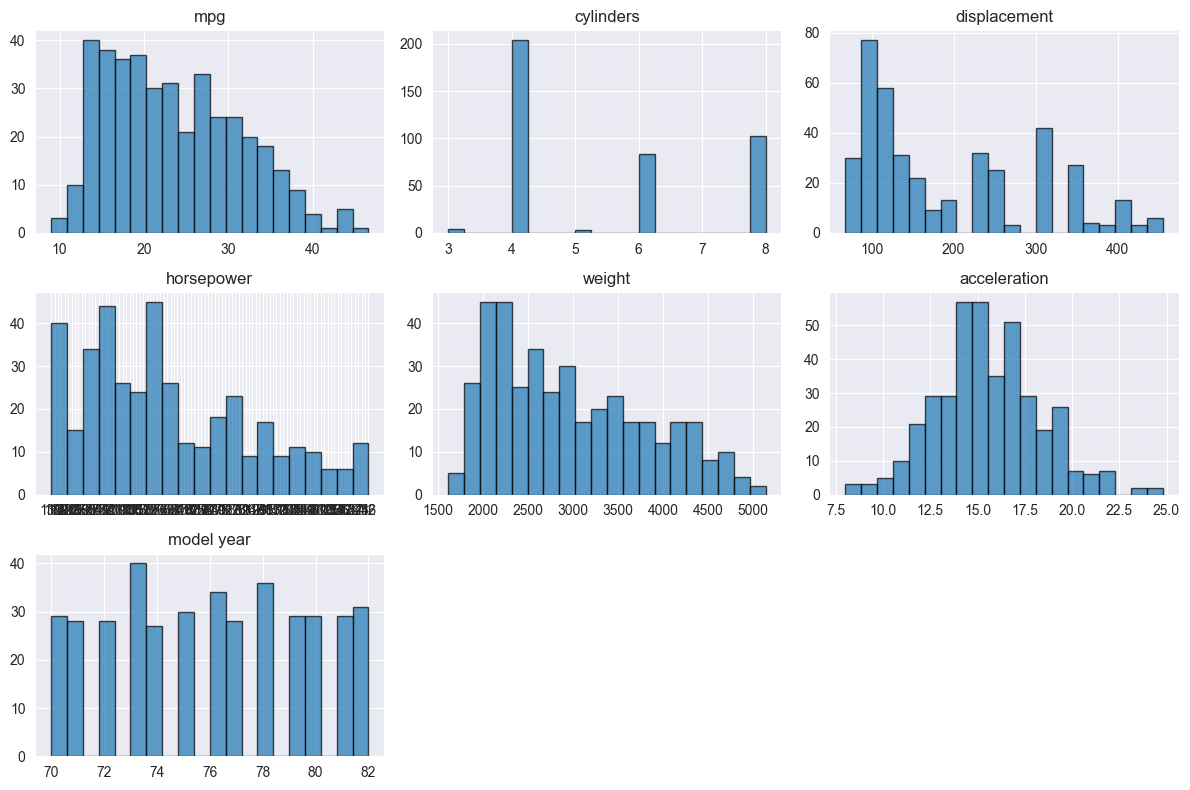

In [24]:
plt.figure(figsize=(12, 8))
features = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[feature], bins=20, edgecolor='black', alpha=0.7)
    plt.title(feature)
    plt.tight_layout()
plt.show()


### 3.4 Корреляционная матрица для количественных признаков

Пропущенные значения после преобразования:
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
dtype: int64

Корреляционная матрица:
                   mpg  cylinders  displacement  horsepower    weight  \
mpg           1.000000  -0.777618     -0.805127   -0.778427 -0.832244   
cylinders    -0.777618   1.000000      0.950823    0.842983  0.897527   
displacement -0.805127   0.950823      1.000000    0.897257  0.932994   
horsepower   -0.778427   0.842983      0.897257    1.000000  0.864538   
weight       -0.832244   0.897527      0.932994    0.864538  1.000000   
acceleration  0.423329  -0.504683     -0.543800   -0.689196 -0.416839   
model year    0.580541  -0.345647     -0.369855   -0.416361 -0.309120   

              acceleration  model year  
mpg               0.423329    0.580541  
cylinders        -0.504683   -0.345647  
displacement     -0.543800   -0.369855  
horsepower       -0.689196   -0.416361  
wei

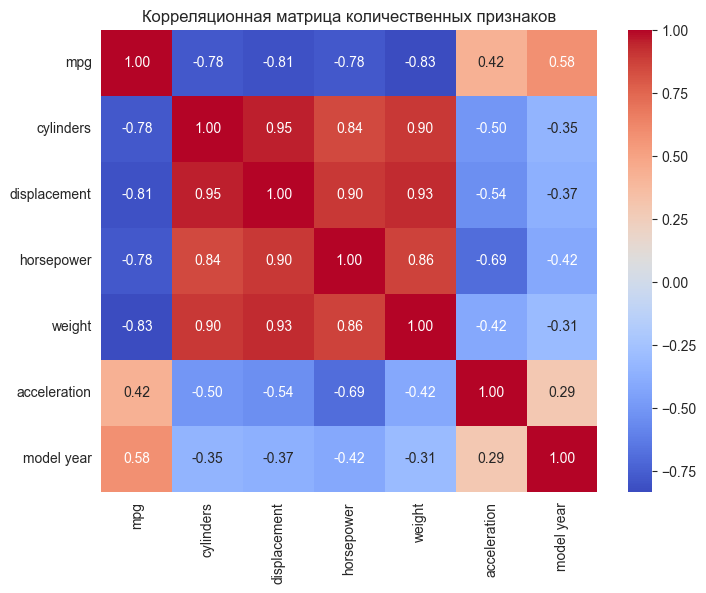

In [25]:
numeric_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']
# Преобразуем столбцы в числовой тип, если необходимо
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print("Пропущенные значения после преобразования:")
print(df[numeric_cols].isnull().sum())
df.dropna(subset=numeric_cols, inplace=True)
corr_matrix = df[numeric_cols].corr()
print("\nКорреляционная матрица:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица количественных признаков')
plt.show()


## Шаг 4. Анализ взаимосвязей факторов

Проверка нормальности распределения для групп по переменной 'origin'
Для применения ANOVA требуется, чтобы данные в каждой группе были нормально распределены.

In [26]:
# Разбиваем данные на группы по 'origin'
group1 = df[df['origin'] == 1]['mpg']
group2 = df[df['origin'] == 2]['mpg']
group3 = df[df['origin'] == 3]['mpg']

print("Проверка нормальности распределения (критерий Шапиро–Уилка):")
for idx, group in zip([1, 2, 3], [group1, group2, group3]):
    w_stat, p_val = stats.shapiro(group)
    print(f"Группа origin = {idx}: W = {w_stat:.3f}, p-значение = {p_val:.3f}")
    if p_val < 0.05:
        print("  --> Распределение не соответствует нормальному.")
    else:
        print("  --> Распределение соответствует нормальному.")

# Обоснование выбора критерия:
# Если хотя бы одна группа не соответствует нормальности, можно дополнительно применить тест Крускала–Уоллиса,
# который является непараметрическим аналогом ANOVA.
if (stats.shapiro(group1)[1] < 0.05 or stats.shapiro(group2)[1] < 0.05 or stats.shapiro(group3)[1] < 0.05):
    print("\nНекоторые группы не удовлетворяют нормальности. Применим тест Крускала–Уоллиса для проверки различий:")
    kruskal_result = stats.kruskal(group1, group2, group3)
    print("Результаты теста Крускала–Уоллиса:")
    print("H-статистика:", kruskal_result.statistic)
    print("p-значение:", kruskal_result.pvalue)
else:
    print("\nВсе группы удовлетворяют нормальности. Применение ANOVA обосновано.")

# Применение однофакторного дисперсионного анализа (ANOVA)
anova_result = stats.f_oneway(group1, group2, group3)
print("\nРезультаты ANOVA:")
print("F-статистика:", anova_result.statistic)
print("p-значение:", anova_result.pvalue)
if anova_result.pvalue < 0.05:
    print("p-значение < 0.05 → нулевая гипотеза отвергается. Средние значения mpg различаются между группами.")
else:
    print("p-значение ≥ 0.05 → нет оснований отвергнуть нулевую гипотезу.")


Проверка нормальности распределения (критерий Шапиро–Уилка):
Группа origin = 1: W = 0.934, p-значение = 0.000
  --> Распределение не соответствует нормальному.
Группа origin = 2: W = 0.946, p-значение = 0.005
  --> Распределение не соответствует нормальному.
Группа origin = 3: W = 0.980, p-значение = 0.242
  --> Распределение соответствует нормальному.

Некоторые группы не удовлетворяют нормальности. Применим тест Крускала–Уоллиса для проверки различий:
Результаты теста Крускала–Уоллиса:
H-статистика: 132.0869646991599
p-значение: 2.0781651131565892e-29

Результаты ANOVA:
F-статистика: 96.60153016314952
p-значение: 8.673818448010683e-35
p-значение < 0.05 → нулевая гипотеза отвергается. Средние значения mpg различаются между группами.


### 2. Корреляционный анализ количественных переменных

In [27]:
# Коэффициент Пирсона
pearson_corr, p_val_pearson = stats.pearsonr(df['mpg'], df['weight'])
print("\nКорреляция Пирсона между mpg и weight:", pearson_corr)
print("p-значение для корреляции Пирсона:", p_val_pearson)

# Коэффициент Спирмена
spearman_corr, p_val_spearman = stats.spearmanr(df['mpg'], df['weight'])
print("\nКорреляция Спирмена между mpg и weight:", spearman_corr)
print("p-значение для корреляции Спирмена:", p_val_spearman)



Корреляция Пирсона между mpg и weight: -0.8322442148315752
p-значение для корреляции Пирсона: 6.0152960514372035e-102

Корреляция Спирмена между mpg и weight: -0.8755851198739869
p-значение для корреляции Спирмена: 2.6623779380252216e-125


### 3. Таблицы сопряженности для категориальных переменных

In [28]:
contingency_table = pd.crosstab(df['origin'], df['cylinders'])
print("\nТаблица сопряженности между origin и cylinders:")
print(contingency_table)

chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)
print("\nХи-квадрат статистика:", chi2)
print("p-значение для теста хи-квадрат:", p_chi2)
print("Степени свободы:", dof)
print("Ожидаемые частоты:\n", expected)



Таблица сопряженности между origin и cylinders:
cylinders  3   4  5   6    8
origin                      
1          0  69  0  73  103
2          0  61  3   4    0
3          4  69  0   6    0

Хи-квадрат статистика: 180.71869417150074
p-значение для теста хи-квадрат: 7.272757264481584e-35
Степени свободы: 8
Ожидаемые частоты:
 [[  2.5        124.375        1.875       51.875       64.375     ]
 [  0.69387755  34.52040816   0.52040816  14.39795918  17.86734694]
 [  0.80612245  40.10459184   0.60459184  16.72704082  20.75765306]]


### Вывод по анализу взаимосвязей

1. Групповое сравнение (ANOVA или тест Крускала–Уоллиса) указывает на статистически значимые различия в среднем значении mpg между группами по 'origin'.
2. Корреляционный анализ показывает сильную отрицательную взаимосвязь между расходом топлива и массой автомобиля.
3. Тест хи-квадрат подтверждает зависимость между регионом производства и числом цилиндров.


# Шаг 5. Регрессионный анализ

## 1. Формирование данных для регрессии

In [29]:
numeric_features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']
X = df[numeric_features].copy()
# Преобразование категориального признака 'origin' в dummy-переменные
origin_dummies = pd.get_dummies(df['origin'], prefix='origin', drop_first=True)
X = pd.concat([X, origin_dummies], axis=1)
y = df['mpg']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 2. Построение модели линейной регрессии


Линейная регрессия:
MSE: 10.60
RMSE: 3.26
MAE: 2.46
R2: 0.79

Коэффициенты линейной модели:
cylinders      -0.342101
displacement    0.019206
horsepower     -0.021620
weight         -0.006423
acceleration    0.042198
model year      0.797161
origin_2        2.875499
origin_3        3.205969
dtype: float64
Перехват (Intercept): -19.33193002500663


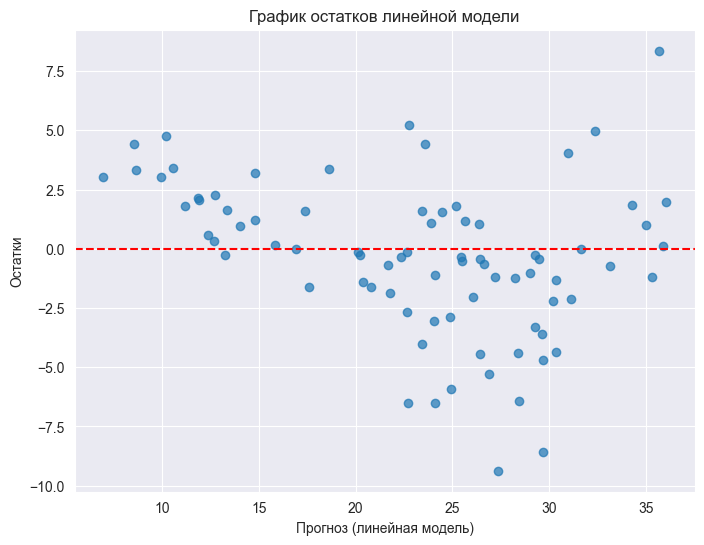

In [30]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("\nЛинейная регрессия:")
print("MSE: {:.2f}".format(mse_linear))
print("RMSE: {:.2f}".format(rmse_linear))
print("MAE: {:.2f}".format(mae_linear))
print("R2: {:.2f}".format(r2_linear))

print("\nКоэффициенты линейной модели:")
coeff_linear = pd.Series(linear_model.coef_, index=X.columns)
print(coeff_linear)
print("Перехват (Intercept):", linear_model.intercept_)

residuals_linear = y_test - y_pred_linear
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_linear, residuals_linear, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Прогноз (линейная модель)')
plt.ylabel('Остатки')
plt.title('График остатков линейной модели')
plt.show()


## 3. Построение модели полиномиальной регрессии (degree=2)


Полиномиальная регрессия (degree=2):
MSE: 7.75
RMSE: 2.78
MAE: 2.03
R2: 0.85

Коэффициенты полиномиальной модели:
[ 1.16483859e+01 -6.45758386e-01  1.74451506e-01  1.56944107e-02
 -8.78703359e+00 -6.67294915e+00 -1.93116316e+01 -1.60012147e+01
 -8.93858117e-01  1.06052216e-02  1.68467502e-02  1.51810005e-03
  4.14761846e-01 -2.16842605e-01 -1.79692234e-01  2.23200910e+00
 -2.40458873e-05  1.04506816e-04  1.23127417e-06 -2.52724924e-03
  7.94770074e-03 -3.99939026e-02  2.10841124e-02 -1.00969016e-04
 -3.54582087e-05 -6.48121083e-03 -1.51792227e-03  2.08865829e-02
 -2.09230849e-02  3.96178433e-07  7.44098212e-06 -3.60388226e-04
  4.20514861e-04 -2.94792965e-04  1.61272717e-03  9.27902991e-02
  1.08112847e+00  6.36875098e-01  4.45566979e-02  3.17111683e-01
  1.78946914e-01 -1.93116316e+01  0.00000000e+00 -1.60012147e+01]
Перехват (Intercept): 331.06210908834817


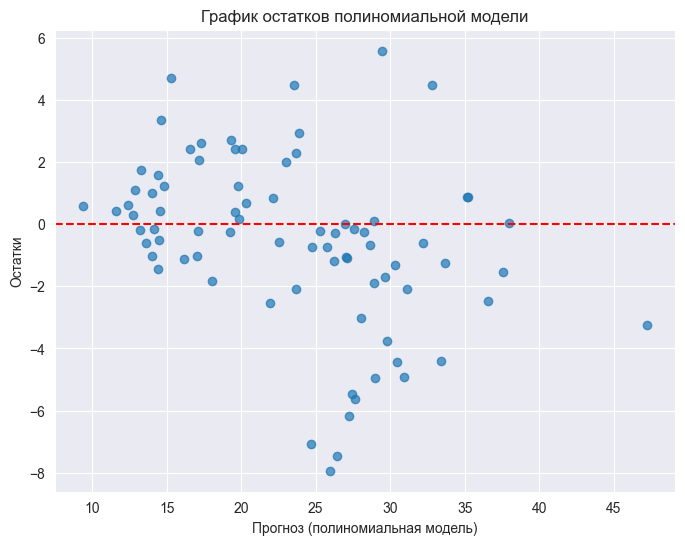

In [31]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print("\nПолиномиальная регрессия (degree=2):")
print("MSE: {:.2f}".format(mse_poly))
print("RMSE: {:.2f}".format(rmse_poly))
print("MAE: {:.2f}".format(mae_poly))
print("R2: {:.2f}".format(r2_poly))

print("\nКоэффициенты полиномиальной модели:")
print(poly_model.coef_)
print("Перехват (Intercept):", poly_model.intercept_)

residuals_poly = y_test - y_pred_poly
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_poly, residuals_poly, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Прогноз (полиномиальная модель)')
plt.ylabel('Остатки')
plt.title('График остатков полиномиальной модели')
plt.show()


## 5. Сравнение моделей и итоговый вывод

In [32]:
print("\nСравнение моделей:")
print("Линейная модель - R2: {:.2f}, RMSE: {:.2f}, MAE: {:.2f}".format(r2_linear, rmse_linear, mae_linear))
print("Полиномиальная модель - R2: {:.2f}, RMSE: {:.2f}, MAE: {:.2f}".format(r2_poly, rmse_poly, mae_poly))

if r2_poly > r2_linear:
    best_model = "Полиномиальная модель"
else:
    best_model = "Линейная модель"

print("\nИтоговый вывод:")
print("Построены две модели для прогнозирования расхода топлива (mpg) на основе факторов автомобиля.")
print("Анализ коэффициентов, графики остатков и вычисленные метрики позволяют оценить адекватность моделей.")
print("Сравнение моделей показало, что {} имеет лучшие показатели качества (более высокий R2 и/или меньшие ошибки).".format(best_model))



Сравнение моделей:
Линейная модель - R2: 0.79, RMSE: 3.26, MAE: 2.46
Полиномиальная модель - R2: 0.85, RMSE: 2.78, MAE: 2.03

Итоговый вывод:
Построены две модели для прогнозирования расхода топлива (mpg) на основе факторов автомобиля.
Анализ коэффициентов, графики остатков и вычисленные метрики позволяют оценить адекватность моделей.
Сравнение моделей показало, что Полиномиальная модель имеет лучшие показатели качества (более высокий R2 и/или меньшие ошибки).
